###### Татур А.А.
###### v0.2
###### 07.11.22
###### Данные - https://www.kaggle.com/competitions/nlp-getting-started/data . Набор представляет собой более 11000 твитов о каких-то катастрофах. Таргетная колонка имеет два значения (0 - нереальная катастрофа, 1-реальная катастрофа). 
###### Инструменты обработки - Векторизация -TF-IDF, Понижение размерности PCA, TSNE.
###### Модель - GaussianNB

###### Цели
Обработать текст (сет) не менее 20000 символов, уменьшить размерность текста, используя метод главных компонент, при этом обеспечить сохранение информации не менее 80%


###### Задачи

1. Загрузка текста
2. Токенизацию
3. Очистка текста (числа, знаки препинания, символы, стоп-слова)
4. Лемматизация
5. Получить обработанную версию текста
6. Построить карту 2D c 10-40 словами что бы посмотреть расположены ли похожие слова рядом или нет
7. Векторизация
8. Применить PCA (потеря информации не более 20%)
9. Обучить модель
10. Выводы

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score
import time

In [2]:
#функция для удаления эмодзи
def remove_emoji(string):
    import re
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [3]:
#обработка текста. Удаление мусорных слов, знаков препинания, приведение к нижнему регистру.
def text_preprocessing(text: str) ->str:
    
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer
    import string
    import re

    text=text.lower()#.replace(' \'s','')
    STOPWORDS  = stopwords.words('english')
    
      
    #Убираем эмоджи
    text = remove_emoji(text)
    
    #Убираем ссылки
    text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)

    
    #Убираем мусорные слова + лемматизация
    no_trash = [word for word in text.split(' ') if word not in STOPWORDS]
    no_trash = ' '.join(no_trash)
    
    #Вычленяем посимвольно знаки препинания и цифры
    no_punct_nodigits = [letter for letter in no_trash if letter not in string.punctuation 
                                                  and letter not in string.digits
                                                  and letter not in '“”']
    no_punct_nodigits = ''.join(no_punct_nodigits)
    
    
    #лемматизация
    lemmatizer = WordNetLemmatizer()
    one_lemma = [lemmatizer.lemmatize(word) for word in no_punct_nodigits]
    text=''.join(one_lemma)
    #после удаления апострофов появляются бесхозные буквы s и t
    
    text=text.replace(' s', '')
    text=text.replace(' t ','')
    
    return text

In [4]:
#Приводим все к векторному виду. на выход pd.DataFrame.
def vectorization(pdseries: pd.Series) ->pd.DataFrame:
    from sklearn.feature_extraction.text import TfidfVectorizer
    
    vectorizer = TfidfVectorizer()
    corp_vect = vectorizer.fit_transform(pdseries)
    
    return pd.DataFrame (corp_vect.toarray(), columns = vectorizer.get_feature_names_out())

In [5]:
df=pd.read_csv ('tweets.csv').drop (['id','location','keyword'],axis=1)

In [6]:
df['text_preprocessing']=df.text.apply(text_preprocessing)

#### целевой параметр и свойства для обучения модельки
X=df.drop(['target','text'], axis=1)
y=df.target

#### Векторизация, понижение размерности, построение графиков

In [ ]:
#Выполняем векторизацию
df_vectorized = vectorization(df.text_preprocessing)

In [ ]:
df_vectorized.shape

In [ ]:
df_vectorized=df_vectorized.astype(np.float16)

In [ ]:
#Выполняем понижение размерности До 2х, при этом транспонируем DataFrame, чтобы поменять столбцы и строки местами
model_PCA = PCA(2)
new_df = model_PCA.fit_transform(df_vectorized.T)
#присваиваем название колонок из предыдущего датафреума как индексы в новом
new_df = pd.DataFrame(new_df, index=df_vectorized.columns)

In [23]:
new_df.shape

(26545, 2)

In [70]:
new_df_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(df_vectorized.T)
new_df_embedded=pd.DataFrame(new_df_embedded, index=df_vectorized.columns)

In [71]:
new_df.shape

(26545, 2)

In [72]:
new_df_embedded.shape

(26545, 2)

In [73]:
new_df.head(5)

,0,1
aa,-0.000145,0.001832
aaaaaaaaacccccckkkkkkkkurvived,-0.006087,-0.007059
aab,-0.004569,-0.004517
aadharcard,-0.005790,-0.006651
aalaathun,-0.006040,-0.006982


In [74]:
new_df_embedded.head(5)

,0,1
aa,36.122284,23.858541
aaaaaaaaacccccckkkkkkkkurvived,39.849133,39.825508
aab,-26.538298,89.424927
aadharcard,-4.337694,-106.976143
aalaathun,-120.754707,-55.153038


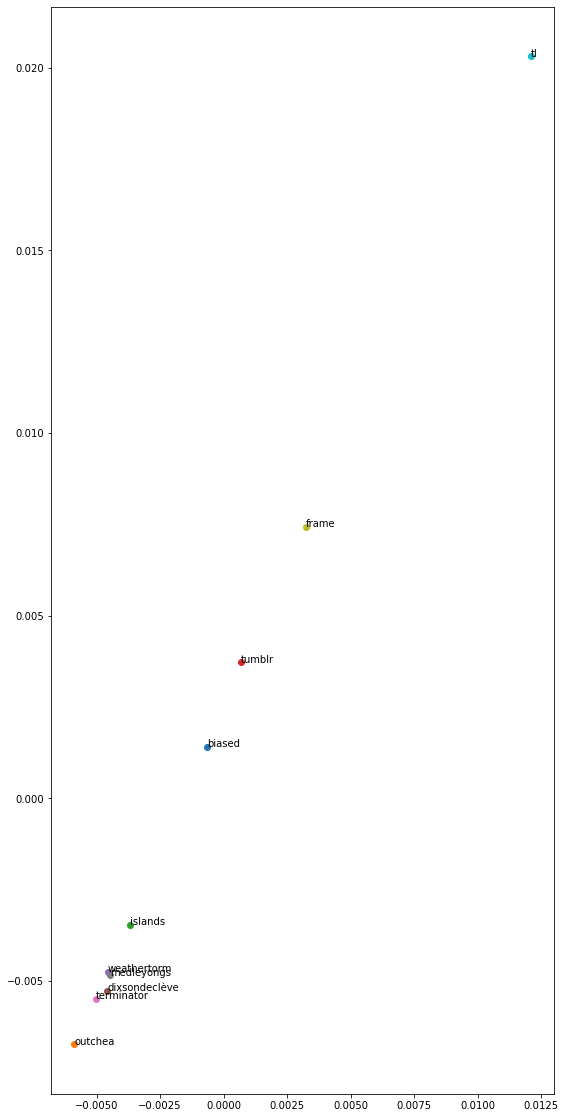

In [12]:
# Строим график 10 случайных слов. после понижения размерности с PCA
plt.figure(figsize=(9,20))

for x in range (10):
    rnd = np.random.RandomState().randint(0,new_df.shape[0]-1)
    word = new_df.iloc[rnd]
    x_c=list(word)[0]
    y_c=list(word)[1]
    plt.scatter(x=x_c, y=y_c)
    plt.annotate(word.name, (x_c, y_c))

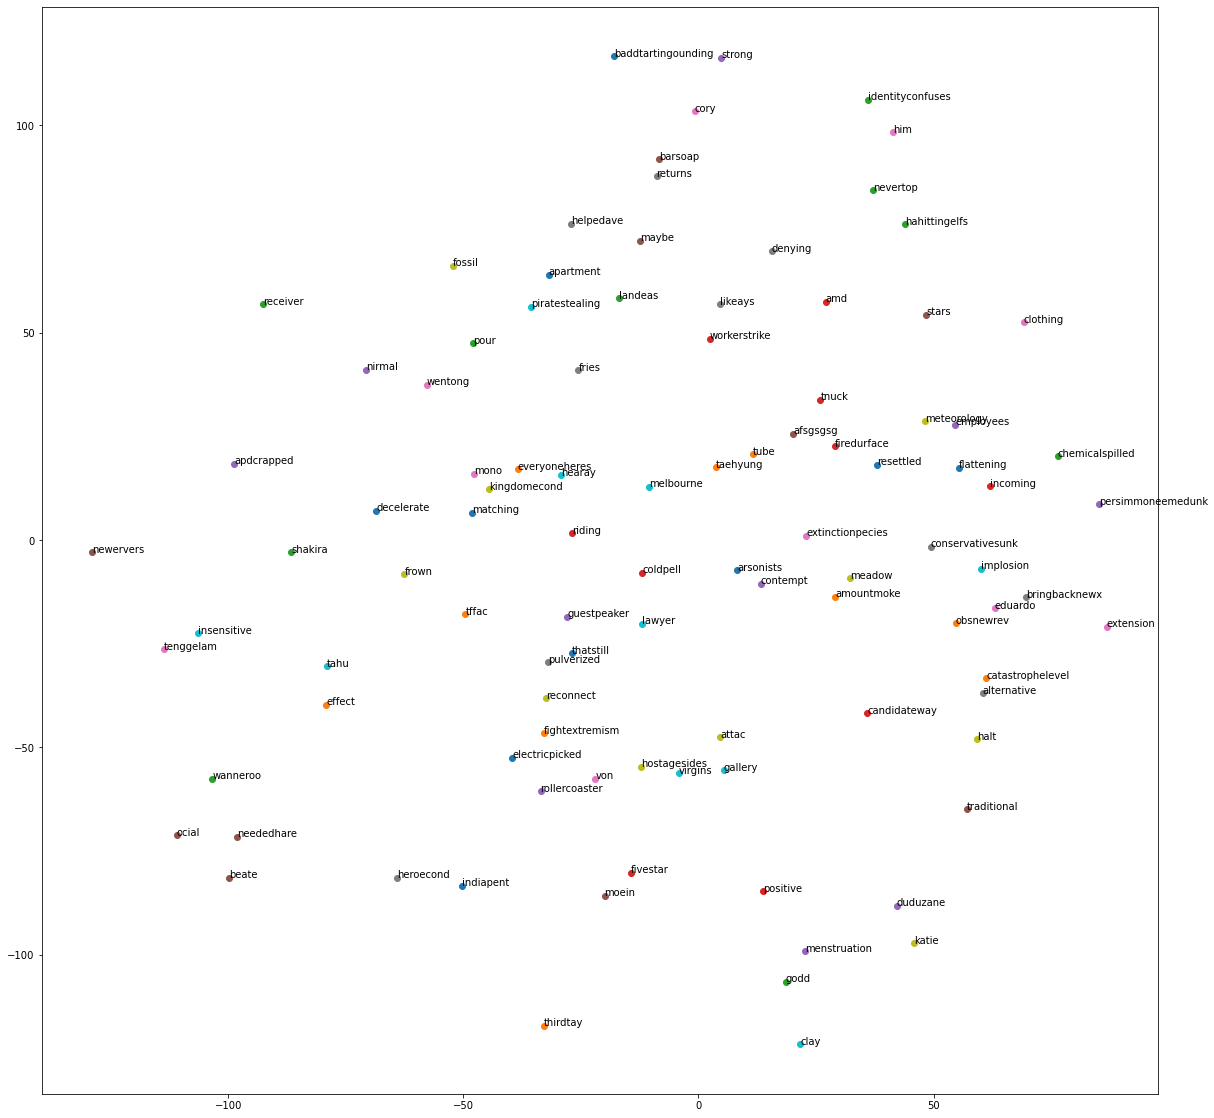

In [76]:
# Строим график 100 случайных слов. после понижения размерности с TSNE
plt.figure(figsize=(20,20))

for x in range (100):
    rnd = np.random.RandomState().randint(0,new_df_embedded.shape[0]-1)
    word = new_df_embedded.iloc[rnd]
    x_c=list(word)[0]
    y_c=list(word)[1]
    plt.scatter(x=x_c, y=y_c)
    plt.annotate(word.name, (x_c, y_c))

In [77]:
#Применяем сначала PCA, снижаем размерность до 50, затем TSNE и снижем до 2х и визуализируем

#Выполняем понижение размерности до 50
model_PCA50 = PCA(n_components=50)
new_df_PCA50 = model_PCA50.fit_transform(df_vectorized.T)
#присваиваем название колонок из предыдущего датафреума как индексы в новом
new_df_PCA50 = pd.DataFrame(new_df_PCA50, index=df_vectorized.columns)

In [78]:
#TSNE на предварительно сниженной размерности до 50
new_df_embedded_PCA50 = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(new_df_PCA50)
new_df_embedded_PCA50=pd.DataFrame(new_df_embedded_PCA50, index=df_vectorized.columns)

C:\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 3585 (\N{THAI CHARACTER KO KAI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 3611 (\N{THAI CHARACTER PO PLA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 3621 (\N{THAI CHARACTER LO LING}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


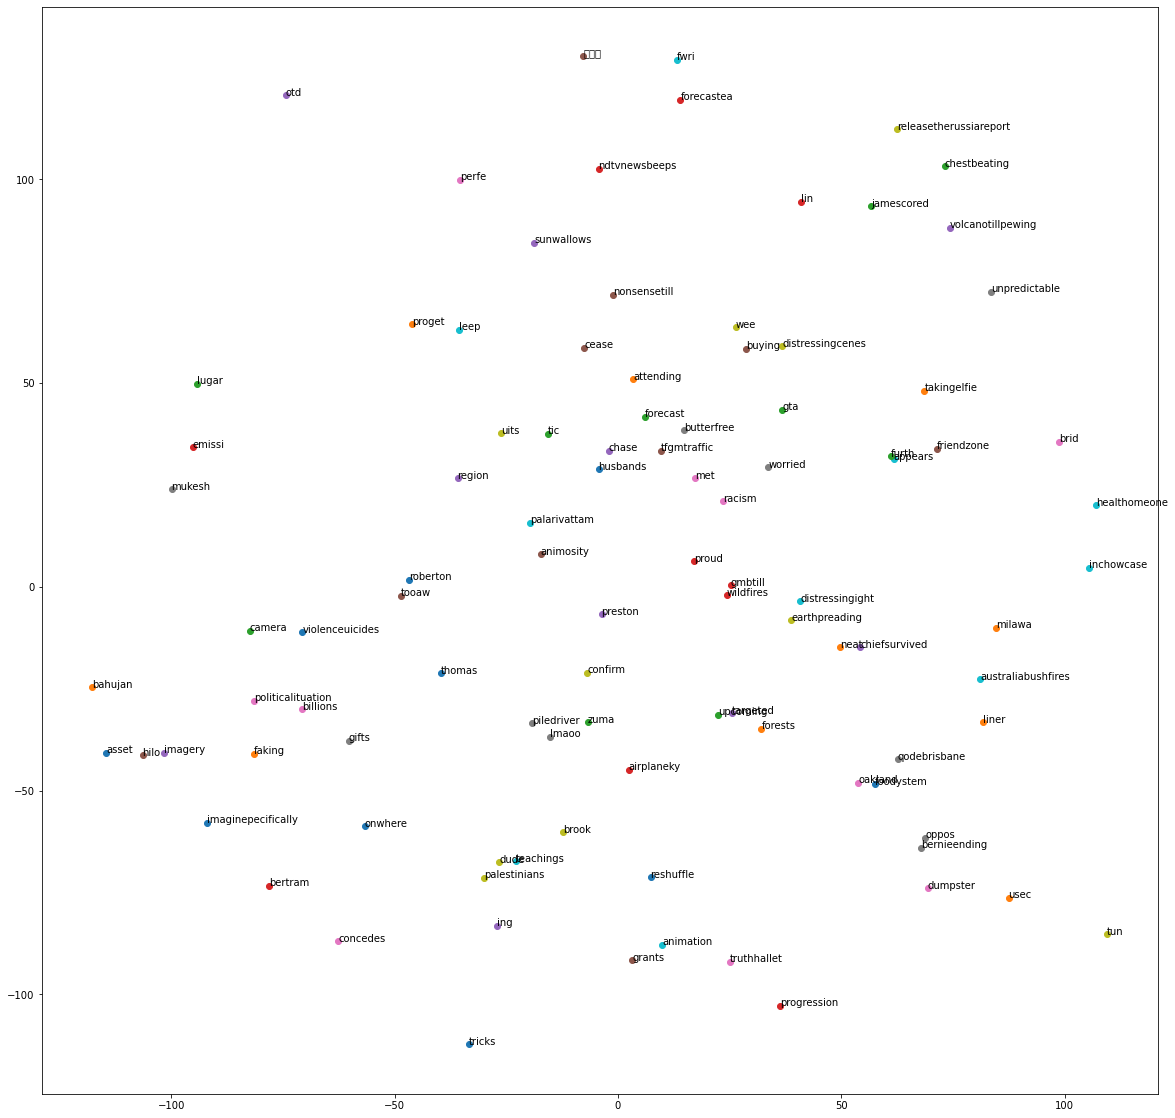

In [79]:
plt.figure(figsize=(20,20))

for x in range (100):
    rnd = np.random.RandomState().randint(0,new_df_embedded_PCA50.shape[0]-1)
    word = new_df_embedded_PCA50.iloc[rnd]
    x_c=list(word)[0]
    y_c=list(word)[1]
    plt.scatter(x=x_c, y=y_c)
    plt.annotate(word.name, (x_c, y_c))

#### Разбиваем выборку на тренировочные. Обучаем модельку

In [7]:
X_train, X_test, y_train, y_test = train_test_split(vectorization(X.text_preprocessing),y, train_size=0.7, random_state=42)

In [23]:
from sklearn.naive_bayes import GaussianNB

start = time.time()
model=GaussianNB()
model.fit(X_train, y_train)
print (time.time() - start, ' секунд')

3.2650763988494873  секунд


In [89]:
predict = model.predict_proba(X_test)[:,1]
roc_auc_score(y_test, predict)

0.710931812989166

#### Понижение размерности методом главных компонент до 20% с последующим обучением модели.

In [8]:
X_train.shape

(7958, 26545)

In [9]:
X_test.shape

(3412, 26545)

In [10]:
model_PCA = PCA(6000)
X_train_PCA = model_PCA.fit_transform(X_train)

In [11]:
X_test_PCA = model_PCA.transform(X_test)

In [12]:
X_train_PCA.shape

(7958, 6000)

In [13]:
X_test_PCA.shape

(3412, 6000)

In [24]:
from sklearn.naive_bayes import GaussianNB

start = time.time()
model=GaussianNB()
model.fit(X_train_PCA, y_train)
print (time.time() - start, ' секунд')

0.8631513118743896  секунд


In [15]:
predict = model.predict_proba(X_test_PCA)[:,1]
roc_auc_score(y_test, predict)

0.49406610002084045

#### Выводы:
    
    1. Проведена предварительная обработка текста для удаления пустых компонентов, выполнена его векторизация
    2. Понижение размерности методом PCA, TSNE, а также их сочетанием позволяет визуализировать
    векторы слов на плосткости, однако по расположению их рядом или на удалении нельзя судить о близости
    этих слов по смыслу, поскольку данные методы не учитываю контекста
    3. Применением понижения размерности негативно влияет на результатах обучения модели, хотя и значительно ускоряет его